In [1]:
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy import constants as c
import astropy.units as u
import multiprocessing
import time

In [2]:
h=cosmo.H0.value/100
fac = c.c**2 / (4 * np.pi * c.G)
fac = fac.to(u.Msun * u.pc**(-2)*u.Mpc).value
comoving = True

In [3]:
data = np.loadtxt('/data/cjia/cluster/planck18_galaxy', unpack=True)
gid = data[0] # group ID
ra = data[1]
dec = data[2]
z = data[3]
mag = data[7]
clr = data[8]
bcg = data[9]

In [4]:
def coord_to_xy(index, rac, decc, zc, phi):
    mask = gid == index
    ra_satellite = ra[mask]
    dec_satellite = dec[mask]
    
    dx = (ra_satellite - rac) * np.cos(decc / 180 * np.pi)  # degree
    dy = dec_satellite - decc                               # degree
    
    scale_d2Mpc = cosmo.angular_diameter_distance(zc).value * h / 180 * np.pi
    scale_Mpc2d = 1 / scale_d2Mpc
    
    dx = dx * scale_d2Mpc  # Mpc
    dy = dy * scale_d2Mpc  # Mpc
    
    theta = 90 - phi
    dx1 = dx * np.cos(theta / 180 * np.pi) - dy * np.sin(theta / 180 * np.pi)
    dy1 = dx * np.sin(theta / 180 * np.pi) + dy * np.cos(theta / 180 * np.pi)
    
    return [dx1, dy1]

46


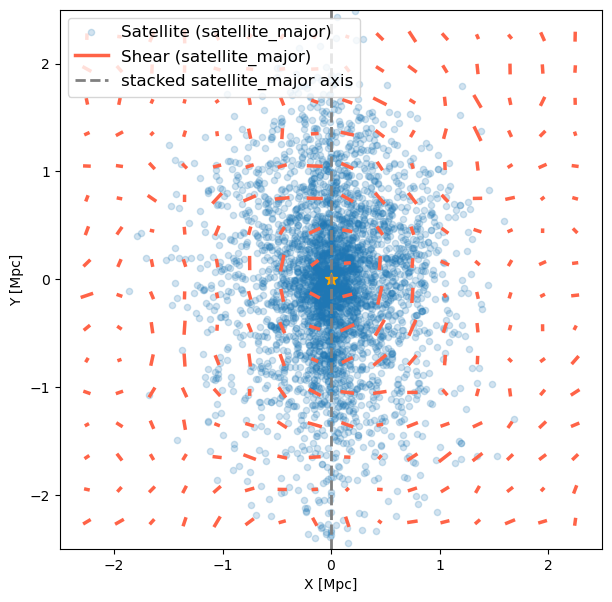

3876


<Figure size 640x480 with 0 Axes>

In [8]:
# input
#mode = 'bcg_major'
#mode = 'rotation'
mode = 'satellite_major'
input_data = np.loadtxt(f'input_{mode}', unpack=True)
raclist = input_data[0]
decclist = input_data[1]
zlist = input_data[2]
philist = input_data[3]
gidlist = input_data[4]

print(len(raclist))

dx_all = []
dy_all = []
for k in range(len(raclist)):
    dx, dy = coord_to_xy(gidlist[k], raclist[k], decclist[k], zlist[k], philist[k])
    dx_all = dx_all + dx.tolist()
    dy_all = dy_all + dy.tolist()
plt.figure(figsize=(7, 7))
plt.scatter(dx_all, dy_all, s=20, label=f'Satellite ({mode})', alpha=0.2)


#### shear

data = np.loadtxt(f'stack_{mode}.txt', unpack=True)
dx = data[0]
dy = data[1]
g1 = data[2]
g2 = data[3]



def get_xy(g1, g2):
    x = 1
    if g1 == 0:
        if g2 > 0:
            y = 1
        elif g2 < 0:
            y = -1
        else:
            return [0, 0]
    elif g1 > 0:
        y = np.tan(np.arctan(g2/g1) / 2)
    else:
        y = - 1 / np.tan(np.arctan(g2/g1) / 2)
    
    scale = np.sqrt(g1**2 + g2**2) / np.sqrt(x**2 + y**2)
    x = x * scale
    y = y * scale
    
    return [x, y]



for k in range(len(dx)):
    xy = get_xy(g1[k], g2[k])
    #plotscale = 1.3
    plotscale = 30
    x = xy[0] * plotscale
    y = xy[1] * plotscale
    plotx = [dx[k] - x, dx[k] + x]
    ploty = [dy[k] - y, dy[k] + y]
    if k == 0:
        plt.plot(plotx, ploty, c='tomato', linewidth=2.5, label=f'Shear ({mode})')
    else:
        plt.plot(plotx, ploty, c='tomato', linewidth=2.5)


plt.scatter(0, 0, s=80, c='orange', marker='*')

####

plt.axvline(0, c='gray', linestyle='--', linewidth=2, label=f'stacked {mode} axis')

lim = 2.5
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xlabel('X [Mpc]')
plt.ylabel('Y [Mpc]')
plt.legend(loc='upper left', fontsize=12)
plt.savefig(f'compare_{mode}.png')
plt.show()
plt.clf()
print(len(dx_all))